In [1]:
import os

try:
    import subprocess
    import sys

    from google.colab import drive

    subprocess.run(["pip", "install", "torchmetrics", "optuna"])
    base_dir = "/content/drive/MyDrive/Colab_Notebooks/Crack_Detection"
    drive.mount("/content/drive")
    sys.path.append(os.path.join(base_dir, "semantic-segmentation"))
    LOCAL = False
except ImportError:
    base_dir = "."
    LOCAL = True

import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import find_boundaries
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall
from torchmetrics.clustering import RandScore

from train import (
    DataLoader,
    ImageMaskTransform,
    SegmentationDataset,
    UNet,
    cross_entropy_weighted,
    init_data_loaders,
    init_datasets,
    tune_hyperparams,
)


%load_ext tensorboard

In [ ]:
%tensorboard --logdir {os.path.join(base_dir, "runs")}

In [2]:
tune_hyperparams(base_dir, LOCAL)

[I 2025-04-11 19:06:51,313] A new study created in RDB with name: study-0411-190650
[I 2025-04-11 19:07:13,966] Trial 0 finished with value: 0.45371294021606445 and parameters: {'flip_prob': 0.1969915717248865, 'rotate_prob': 0.015956805291706722, 'elastic_prob': 0.5457119704182659, 'translate_prob': 0.08544510908673897, 'brightness_prob': 0.47042942437412416, 'dropout_p': 0.33341260574975223, 'vanilla_loss': True, 'use_adam': False, 'lr': 0.0009350254066059368, 'momentum': 0.2563052094361924, 'use_cosine_scheduler': True, 'min_lr': 9.363967334239953e-08, 'cosine_scheduler_config': 2}. Best is trial 0 with value: 0.45371294021606445.
[I 2025-04-11 19:07:36,299] Trial 1 finished with value: 0.3202427625656128 and parameters: {'flip_prob': 0.2288978727950785, 'rotate_prob': 0.41387044116648963, 'elastic_prob': 0.3252680199127356, 'translate_prob': 0.16678119043431883, 'brightness_prob': 0.3142958207755327, 'dropout_p': 0.12322336280243155, 'vanilla_loss': True, 'use_adam': True, 'lr': 0.

KeyboardInterrupt: 

In [12]:
storage = "sqlite:///Data/seg-study.db"
studies = optuna.study.get_all_study_summaries(storage=storage)
print("Num of studies:", len(studies))
study = studies[-1]
print(study.study_name)
study = optuna.load_study(study_name=study.study_name, storage=storage)

Num of studies: 49
study-0411-185225


In [6]:
len(study.trials[0].distributions.keys())

15

In [4]:
(
    batch_size,
    train_image_dir,
    train_images,
    train_mask_dir,
    val_images,
    val_percent,
) = init_datasets()

flip_prob = 0.1
rotate_prob = 0.1
elastic_prob = 0.11
translate_prob = 0.1
brightness_prob = 0.1
train_dataloader, val_dataloader = init_data_loaders(
    batch_size,
    brightness_prob,
    elastic_prob,
    flip_prob,
    rotate_prob,
    train_image_dir,
    train_images,
    train_mask_dir,
    translate_prob,
    val_images,
)

In [ ]:
for images, masks in train_dataloader:
    image = images[0].permute(1, 2, 0).cpu().numpy()
    mask = masks[0].cpu().numpy().squeeze()
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image, cmap="gray")
    axs[1].imshow(mask, cmap="gray")
    assert image.shape[:2] == (572, 572)
    assert mask.shape == (388, 388)
    plt.show()

In [ ]:
loss_w0, loss_sigma = 5, 5
loss_w1 = 1.0
dropout_p = 0.2
vanilla_loss = True

test_image_dir = os.path.join(base_dir, "isbi_2012_challenge/test/imgs")
test_mask_dir = os.path.join(base_dir, "isbi_2012_challenge/test/labels")

test_images = os.listdir(test_image_dir)
test_transforms = ImageMaskTransform(train=False)
test_dataset = SegmentationDataset(
    test_image_dir, test_mask_dir, test_images, transform=test_transforms
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

pretrained_weights_path = "checkpoints/C1.pth"
model = UNet(dropout_p=dropout_p)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))
model.eval()

accuracy_metric_test = BinaryAccuracy().to(device)
precision_metric_test = BinaryPrecision().to(device)
recall_metric_test = BinaryRecall().to(device)
rand_score_metric_test = RandScore().to(device)
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        labels = labels.squeeze(1)
        loss = cross_entropy_weighted(
            outputs,
            labels,
            device,
            loss_w0,
            loss_sigma,
            loss_w1,
            vanilla=vanilla_loss,
        )
        test_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        accuracy_metric_test.update(preds, labels)
        recall_metric_test.update(preds, labels)
        precision_metric_test.update(preds, labels)
        rand_score_metric_test.update(preds.view(-1), labels.view(-1))

print(
    f"(Test) Loss: {test_loss / len(test_dataloader):.4f}, "
    f"Rand error: {1 - rand_score_metric_test.compute():.4f} "
    f"Pixel Error: {1 - accuracy_metric_test.compute():.4f} "
    f"Recall: {recall_metric_test.compute():.4f} "
    f"Precision: {precision_metric_test.compute():.4f}"
)

In [ ]:
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        image = images[0].permute(1, 2, 0).cpu().numpy()
        mask = labels[0].cpu().numpy().squeeze()

        predicted_mask = torch.argmax(outputs[0], dim=0).cpu().numpy()

        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        axs[0].imshow(image, cmap="gray")
        axs[0].set_title("Image")
        axs[0].axis("off")

        axs[1].imshow(mask, cmap="gray")
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis("off")

        axs[2].imshow(predicted_mask, cmap="gray")
        axs[2].set_title("Predicted Mask")
        axs[2].axis("off")

plt.show()

tensor([4.8139, 1.2622]) tensor(150544)
tensor([[[[4.8139, 4.8139, 4.8139,  ..., 1.2622, 1.2622, 1.2622],
          [4.8139, 4.8139, 4.8139,  ..., 1.2622, 1.2622, 1.2622],
          [4.8139, 4.8139, 4.8139,  ..., 1.2622, 1.2622, 1.2622],
          ...,
          [4.8139, 4.8139, 4.8139,  ..., 1.2622, 1.2622, 1.2622],
          [4.8139, 4.8139, 4.8139,  ..., 1.2622, 1.2622, 1.2622],
          [4.8139, 4.8139, 4.8139,  ..., 1.2622, 1.2622, 1.2622]]]])


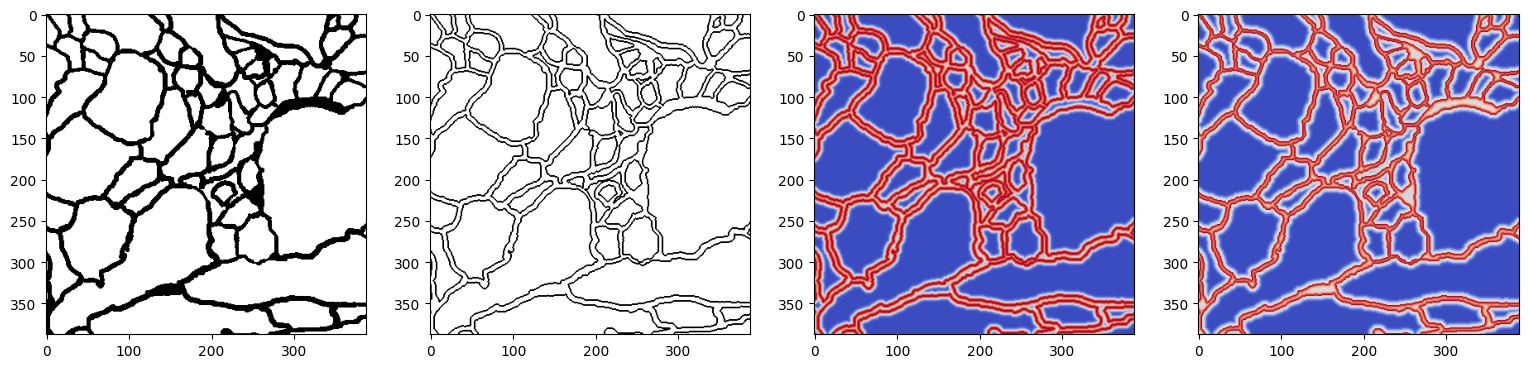

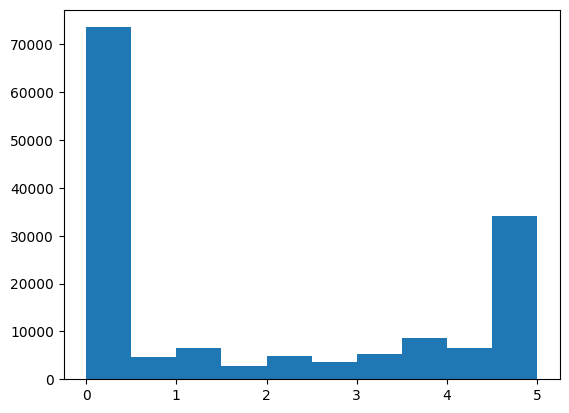

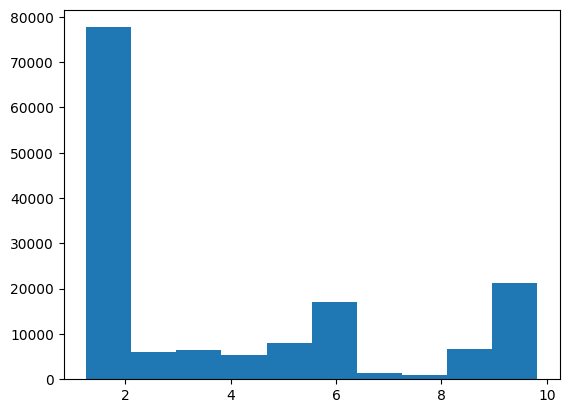

In [10]:
W0, SIGMA = 5, 5
for images, labels in train_dataloader:
    borders = find_boundaries(labels)
    dist = distance_transform_edt(~borders)
    w = W0 * np.exp(-2 * dist**2 / SIGMA**2)

    labels_bincount = torch.bincount(labels.flatten())
    w_class = labels_bincount.sum() / labels_bincount
    print(w_class, labels_bincount.sum())

    class_map = w_class[labels]
    print(class_map)

    w_final = class_map.numpy() + w

    fig, axs = plt.subplots(1, 4, figsize=(19, 6))
    axs[0].imshow(labels.squeeze(), cmap="gray")
    axs[1].imshow(~borders.squeeze(), cmap="gray")
    axs[2].imshow(w.squeeze(), cmap="coolwarm")
    axs[3].imshow(w_final.squeeze(), cmap="coolwarm")
    plt.show()
    plt.hist(w.flatten(), bins=10)
    plt.show()
    plt.hist(w_final.flatten(), bins=10)
    break